In [14]:
import streamlit as st
import sqlite3
import os
import re
import datetime
import random
import pandas as pd

# Import necessary components from your workflow code
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from pydantic import BaseModel, Field
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.agents import AgentExecutor
from langchain.tools import tool
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate
)
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# Import your custom prompts (ensure your prompts.py is in the same directory)
from prompts import *

# --- Configuration for Azure OpenAI ---
OPENAI_DEPLOYMENT_ENDPOINT = "https://az-openai-document-question-answer-service.openai.azure.com/" 
OPENAI_API_KEY = "5d24331966b648738e5003caad552df8" 
OPENAI_API_VERSION = "2023-05-15"
OPENAI_DEPLOYMENT_NAME = "az-gpt_35_model"
OPENAI_MODEL_NAME="gpt-3.5-turbo"
OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME = "az-embedding_model" 
OPENAI_ADA_EMBEDDING_MODEL_NAME = "text-embedding-ada-002"
encoding_name = "cl100k_base"

# Initialize LLM and embedding model
llm = AzureChatOpenAI(
    temperature=0.1,
    deployment_name=OPENAI_DEPLOYMENT_NAME,
    model_name=OPENAI_MODEL_NAME,
    azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=OPENAI_API_KEY            
)
embedding_model = AzureOpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY,
    deployment=OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME,
    model=OPENAI_ADA_EMBEDDING_MODEL_NAME,
    azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT
)

# --- Define Data Models and Workflow Nodes (as in your notebook code) ---
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, START, END

class GraphState(TypedDict):
    user_query: str                 
    domain_confidences: List[Dict[str, Any]]  
    domains: List[str]              
    intent: str                     
    intent_confidence: float        
    tables: List[str]               
    metadata: Dict[str, str]        
    retrieved_docs: List[Any]       
    sql_queries: List[str]          
    verification: str               
    query_history: List[str]        
    error_history: List[str]        
    sql_result_str: str             
    nl_response: str                
    visualization_response: str
    report_response: str
    chat_history: List[str]         
    report: bool                    
    visualize: bool
    visual_instructions: str
    sql_result_df_list: List[Any]   
    goals: List[str]

# Define IntentModel and parser
class IntentModel(BaseModel):
    """Represents the user's query intent."""
    intent: str = Field(
        description="A short string describing the user's intent, breaking down complex queries into simpler parts."
    )
    confidence: float = Field(
        description="A float between 0 and 1 indicating how confident the system is about the intent."
    )
    report: bool = Field(
        description="True if the user explicitly requests a report; otherwise, false."
    )
    visualize: bool = Field(
        description="True if the user explicitly requests a visualization; otherwise, false."
    )
    visual_instructions: str = Field(
        default="",
        description="Any specific instructions provided by the user for the visualization."
    )

structured_llm_intent = llm.with_structured_output(schema=IntentModel, method='function_calling')

system = """\
You are an assistant that identifies the user's intent from a query. The Intent will be used to create SQL query to query tables. So Generate the Intent in a way which will be helpful in future chains , SQL query 
generation and Table identification. Break down complex user query into simpler queries if necessary.
Expand Abbreviation wherever possible.
Return a JSON object with the following fields:
- 'intent': a string describing the user's overall intent only for the SQL query to be generated.
- 'confidence': a float between 0 and 1 indicating how certain you are about the intent.
- 'report': a boolean that is true ONLY if the user explicitly requests a report (for example, if the query includes phrases like 'generate a report', 'export', or 'create a report'); otherwise, false.
- 'visualize': a boolean that is true ONLY if the user explicitly requests a visualization (for example, if the query includes phrases like 'visualize', 'graph', 'chart', or 'plot'); otherwise, false.
- 'visual_instructions': a string containing any specific instructions provided by the user for visualization; if none are provided, return an empty string.
"""
intent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User query: {user_query}"),
    ]
)

# Combine the prompt with the structured output LLM
intent_detector = intent_prompt | structured_llm_intent

# 4. Sample usage
def identify_intent(user_query: str) -> IntentModel:
    """
    Classifies the user's query into an IntentModel (intent + confidence).
    """
    # Pass variables to the prompt via invoke
    result = intent_detector.invoke({"user_query": user_query})
    return result  # This is an IntentModel instance

def intent_identification_node(state: GraphState) -> GraphState:
    print("---INTENT IDENTIFICATION---")
    intent_result = identify_intent(state["user_query"])
    state["intent"] = intent_result.intent
    state["intent_confidence"] = intent_result.confidence
    state["report"] = intent_result.report
    state["visualize"] = intent_result.visualize
    state["visual_instructions"] = intent_result.visual_instructions
    return state



# SQL Generation Node (simplified version)

sql_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", sql_gen_system),
        ("system", census_domain_instructions),
        ("system", census_sample_sql_queries),
        ("system", census_table_metadata),
        ("system", census_entity_relationships),
        (
            "human",
            """\
Previous Queries Tried:
{query_history}

Errors Encountered:
{error_history}

User query: {user_query}
Intent: {intent}
"""
        ),
    ]
)

def sql_generation_node(state: dict) -> dict:
    print("---SQL GENERATION NODE---")
    query_history_str = "\n".join(state.get("query_history", [])) or "None"
    error_history_str = "\n".join(state.get("error_history", [])) or "None"
    prompt_value = sql_prompt.format_prompt(
        user_query=state.get('user_query', ""),
        intent=state.get('intent', ""),
        query_history=query_history_str,
        error_history=error_history_str
    )
    result = llm.invoke(prompt_value)
    raw_query = result.content.strip().strip("```").strip()
    queries = re.split(r';\s*(?=SELECT)', raw_query, flags=re.IGNORECASE)
    queries = [q.strip() for q in queries if q.strip()]
    queries = [q if q.endswith(';') else q + ';' for q in queries]
    state["sql_queries"] = queries
     # Update query history
    if "query_history" not in state:
        state["query_history"] = []
    state["query_history"].extend(queries)
    return state

# For executing SQL queries, assume we have a function to execute against your SQLite DB.
def execute_query_node(state: dict) -> dict:
    sql_queries = state.get("sql_queries", [])
    if not sql_queries:
        error_msg = "No SQL queries found."
        state["sql_result_str"] = error_msg
        state.setdefault("error_history", []).append(error_msg)
        state["execution_error"] = True
        return state

    result_str_list = []
    df_list = []
    execution_error = False

    # For demonstration, we execute against our local SQLite DB (census.db)
    db_filename = "census.db"
    if not os.path.exists(db_filename):
        error_msg = f"Database file '{db_filename}' not found."
        state["sql_result_str"] = error_msg
        state.setdefault("error_history", []).append(error_msg)
        state["execution_error"] = True
        return state

    conn = sqlite3.connect(db_filename)

    # Debug: list available tables in the database
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    print("Available tables in DB:", tables)
    state["available_tables"] = tables  # Save the list for debugging if needed

    for i, query in enumerate(sql_queries):
        # Remove trailing semicolon(s) for better compatibility with SQLite
        query_to_execute = query.strip().rstrip(';')
        print(f"Executing Query {i+1}: {query_to_execute}")
        try:
            df = pd.read_sql_query(query_to_execute, conn)
            df_list.append(df)
            if df.empty:
                result_str = f"Query {i+1}: No rows returned."
            else:
                result_str = f"Query {i+1}:\n" + df.to_markdown()
            result_str_list.append(result_str)
        except Exception as e:
            error_msg = f"Error executing Query {i+1}:\n{query_to_execute}\nException: {e}"
            print(error_msg)
            result_str_list.append(error_msg)
            execution_error = True
            state.setdefault("error_history", []).append(error_msg)
    conn.close()
    state["sql_result_str"] = "\n\n".join(result_str_list)
    state["sql_result_df_list"] = df_list
    state["execution_error"] = execution_error
    return state



from typing import Literal


def handle_execution_result(state) -> Literal["sql_generation", "final_output"]:
    """
    After SQL execution:
      - If an execution error occurred, return "sql_generation" to regenerate the query.
      - Otherwise, return "final_output" (a composite node that will generate NL response and optional visualizations and reports).
    """
    if state.get("execution_error"):
        return "sql_generation"
    else:
        return "final_output"

    
def handle_sql_generation_result(state) -> Literal["report_generation", "execute_query"]:
    """
    Decide the next node based on the report flag.
    If state["report"] is True, route directly to report_generation.
    Otherwise, route to execute_query.
    """
    if state.get("report", False):
        return "report_generation"
    else:
        return "execute_query"

def handle_report_generation_result(state) -> Literal["sql_generation", END]:
    """
    Conditional function for the report generation node:
      - If state["report_generation_error"] is True, return "sql_generation"
        to have the system re-generate the query.
      - Otherwise, return "END" to complete the workflow.
    """
    if state.get("report_generation_error", False):
        print("Report generation error detected. Routing back to SQL generation.")
        return "sql_generation"
    else:
        return END

def nl_response_node(state: GraphState) -> GraphState:
    st.write("Generating NL response from SQL results...")
    response_system = "You are a helpful assistant that summarizes SQL query results."
    response_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", response_system),
            ("human", "Original question: {user_query}\n\nSQL results:\n{sql_result}\n\nProvide a concise answer.")
        ]
    )
    prompt_value = response_prompt.format_prompt(
        user_query=state["user_query"],
        sql_result=state["sql_result_str"]
    )
    raw_response = llm.invoke(prompt_value)
    state["nl_response"] = raw_response.content
    return state

import pandas as pd
import datetime

def report_generation_node(state: dict) -> dict:
    """
    Generates a structured CSV report using the DataFrames stored in state["sql_result_df_list"].
    This avoids re-running the SQL queries. If an error occurs while writing CSVs,
    we append the error message to state["error_history"] and set state["report_generation_error"].
    """
    print("---REPORT GENERATION NODE---")
    try:
        # Retrieve the DataFrames from the state
        df_list = state.get("sql_result_df_list", [])
        sql_queries = state.get("sql_queries", [])
        
        output_dir = "/Workspace/Users/sujay.nagvekar@valuemomentum.com/report_results"
        os.makedirs(output_dir, exist_ok=True)

        csv_file_paths = []
        for i, df_pd in enumerate(df_list):
            try:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                csv_filename = f"query_{i+1}_{timestamp}_result.csv"
                csv_path = os.path.join(output_dir, csv_filename)
                df_pd.to_csv(csv_path, index=False)
                csv_file_paths.append(csv_path)
                print(f"Query {i+1} result saved at: {csv_path}")
            except Exception as e:
                error_msg = f"Error writing CSV for Query {i+1}: {e}"
                print(error_msg)
                csv_file_paths.append(error_msg)
                if "error_history" not in state:
                    state["error_history"] = []
                state["error_history"].append(error_msg)
                state["report_generation_error"] = True

        state["csv_file_paths"] = csv_file_paths

    except Exception as e:
        error_msg = f"Critical error in report generation: {e}"
        print(error_msg)
        if "error_history" not in state:
            state["error_history"] = []
        state["error_history"].append(error_msg)
        state["report_generation_error"] = True

    state["report_response"] = f"Report generated. CSV files in {output_dir}"
    return state


# Define the VisualizationGoals model
def summarize_df(df):
    """
    Given a Pandas DataFrame, return a short summary string:
    e.g., "Columns: col1, col2, col3; Rows: 100"
    """
    cols = ", ".join(df.columns)
    return f"Columns: {cols}; Rows: {df.shape[0]}"

def get_sql_result_summary(state: dict) -> str:
    """
    Extracts a summary string from the list of DataFrames stored in state["sql_result_df_list"].
    If multiple DataFrames exist, summaries are joined with newlines.
    """
    df_list = state.get("sql_result_df_list", [])
    summaries = []
    for i, df in enumerate(df_list):
        summaries.append(f"Query {i+1}: {summarize_df(df)}")
    # If no DataFrame exists, return an empty string
    return "\n".join(summaries) if summaries else "No SQL results available."


class VisualizationGoals(BaseModel):
    """
    Represents the visualization goals to be achieved by the visuals.
    Exactly 3 concise and actionable goals should be returned.
    """
    goals: List[str] = Field(
        default_factory=list,
        description="A list of exactly 3 visualization goals to guide the creation of visuals."
    )


# Create a structured LLM that outputs a VisualizationGoals JSON object
structured_llm_visualization = llm.with_structured_output(schema=VisualizationGoals, method='function_calling')

# Create a prompt template for visualization goals
visualization_system = """\
You are a data visualization expert. Based on the user's query, the detected intent, the provided visualization instructions, and a summary of the SQL query results, generate exactly 3 concise visualization goals that the visuals should achieve.
Return a JSON object in the following format:
{{
  "goals": [
    "Visualization goal 1",
    "Visualization goal 2",
    "Visualization goal 3"
  ]
}}
"""

visualization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", visualization_system),
        ("human", "User query: {user_query}\nIntent: {intent}\nVisualization instructions: {visual_instructions}\nSQL Result Summary: {sql_result_summary}")
    ]
)

# Combine the prompt and the structured LLM
visualization_detector = visualization_prompt | structured_llm_visualization

def identify_visualization_goals(user_query: str, intent: str, visual_instructions: str, sql_result_summary: str) -> VisualizationGoals:
    """
    Generates visualization goals based on:
      - user_query: the original query text
      - intent: the detected intent from the user's query
      - visual_instructions: any explicit instructions the user provided for visualization
      - sql_result_summary: a brief summary of the SQL query results (e.g. key columns, row counts)
    Returns an instance of VisualizationGoals.
    """
    inputs = {
        "user_query": user_query,
        "intent": intent,
        "visual_instructions": visual_instructions,
        "sql_result_summary": sql_result_summary
    }
    result = visualization_detector.invoke(inputs)
    return result


def identify_visualization_goals_from_state(state: dict):
    """
    Extracts inputs from the state (user_query, intent, visual_instructions, and a summary of the SQL result DataFrames)
    and passes them to the visualization goal detection chain.
    
    This function uses your existing 'identify_visualization_goals' function (which expects:
      user_query, intent, visual_instructions, sql_result_summary)
    and returns the resulting VisualizationGoals object.
    """
    # Extract the SQL result summary from the stored DataFrames.
    sql_result_summary = get_sql_result_summary(state)
    
    # Extract the other required state values.
    user_query = state.get("user_query", "")
    intent = state.get("intent", "")
    visual_instructions = state.get("visual_instructions", "")
    
    # Now call the visualization goal detection chain.
    # (Assuming you have defined the function 'identify_visualization_goals'
    # as in the previous example.)
    viz_goals = identify_visualization_goals(user_query, intent, visual_instructions, sql_result_summary)
    state["goals"] = viz_goals.goals
    return state

    
def visualization_generation_node(state: dict) -> dict:
    """
    Uses the SQL result DataFrames (state["sql_result_df_list"]), visualization goals (state["goals"]),
    intent, and visual_instructions to generate Python code (using seaborn) that creates visuals.
    The generated code is executed in an environment where the DataFrame list is available.
    Visuals are saved to a designated output directory, and the output path is stored in state["visualization_output"].
    """
    print("---VISUALIZATION GENERATION NODE---")
    
    # Prepare a summary of the SQL result DataFrames.
    def summarize_df(df):
        cols = ", ".join(df.columns)
        return f"Columns: {cols}; Rows: {df.shape[0]}"
    
    sql_summaries = []
    for i, df in enumerate(state.get("sql_result_df_list", [])):
        sql_summaries.append(f"Query {i+1}: {summarize_df(df)}")
    sql_summary = "\n".join(sql_summaries) if sql_summaries else "No SQL results available."
    
    # Extract necessary state values.
    user_query = state.get("user_query", "")
    intent = state.get("intent", "")
    visual_instructions = state.get("visual_instructions", "No specific instructions provided.")
    goals = state.get("goals", [])
    
    # Create a prompt for visualization code generation.
    prompt = f"""
You are a data visualization expert. Based on the following inputs, generate Python code using the seaborn library that produces visuals.
The code should define a function named create_visuals(df_list) that takes a list of Pandas DataFrames (each corresponding to an SQL query result) as input and creates and saves visuals (e.g., PNG files) to the directory "/Workspace/Users/sujay.nagvekar@valuemomentum.com/visualizations/".

Inputs:
User Query: {user_query}
Detected Intent: {intent}
Visualization Goals:
- {goals[0] if len(goals) > 0 else "N/A"}
- {goals[1] if len(goals) > 1 else "N/A"}
- {goals[2] if len(goals) > 2 else "N/A"}
Visualization Instructions: {visual_instructions}
SQL Results Summary:
{sql_summary}

The generated code should:
1. Import seaborn (and matplotlib as needed).
2. Create visuals for the provided DataFrames.
3. Save each visual as a PNG file in the directory "/Workspace/Users/sujay.nagvekar@valuemomentum.com/visualizations/".
4. Return nothing.
Output only valid Python code.
"""
    # Call the LLM to generate the visualization code.
    response_message = llm.invoke(prompt)
    visualization_code = response_message.content.strip()
    if visualization_code.startswith("```python"):
        visualization_code = visualization_code[len("```python"):].strip()
    elif visualization_code.startswith("```"):
        visualization_code = visualization_code[3:].strip()
    if visualization_code.endswith("```"):
        visualization_code = visualization_code[:-3].strip()
    
    # print("Generated visualization code:")
    # print(visualization_code)
    
    # 6. Save the generated code to a file.
    code_output_file = "visualization.py"
    with open(code_output_file, "w") as f:
        f.write(visualization_code)
    
    # 7. Prepare an execution environment where df_list is available.
    exec_globals = {
        "__name__": "__main__",
        "os": os,
        "pd": pd,
        "sns": __import__("seaborn"),
        "plt": __import__("matplotlib.pyplot"),
        "visuals_dir": "visualizations/"
    }
    # Make the SQL result DataFrames available as df_list.
    exec_globals["df_list"] = state.get("sql_result_df_list", [])
    
    try:
        exec(visualization_code, exec_globals)
        if "create_visuals" in exec_globals and callable(exec_globals["create_visuals"]):
            exec_globals["create_visuals"](exec_globals["df_list"])
            state["visualization_output"] = exec_globals["visuals_dir"]
            print("Visualizations created and saved in:", exec_globals["visuals_dir"])
        else:
            state["visualization_output"] = "Visualization function not defined."
            print("Error: 'create_visuals' function not found in generated code.")
    except Exception as e:
        error_msg = f"Error executing visualization code: {e}"
        print(error_msg)
        state["visualization_output"] = error_msg
        if "error_history" not in state:
            state["error_history"] = []
        state["error_history"].append(error_msg)
    
    state["visualization_response"] = f"Visualization process complete. Visuals saved in {state['visualization_output']}."
    return state

def final_output_node(state: dict) -> dict:
    """
    Composite final node:
      - Always generate an NL response.
      - If state["visualize"] is True, also generate visualization output.
      - If state["report"] is True, also generate report output.
    The node updates the state with keys:
      - state["nl_response"]
      - state["visualization_output"] (e.g., a file path or generated code)
      - state["report_output"] (e.g., a file path)
    """
    print("---FINAL OUTPUT NODE---")
    
    # Generate the natural language response
    state = nl_response_node(state)
    
    # If visualization is requested, generate visualization output.
    if state.get("visualize", False):
        state = identify_visualization_goals_from_state(state)
        state = visualization_generation_node(state)
    
    # If a report is requested, generate report output.
    if state.get("report", False):
        state = report_generation_node(state)
    
    return state

# --- Assemble the Workflow using your StateGraph ---
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("intent_identification", intent_identification_node)
workflow.add_node("sql_generation", sql_generation_node)
workflow.add_node("execute_query", execute_query_node)
workflow.add_node("natural_language_response", nl_response_node)
workflow.add_node("visualization_generation", visualization_generation_node)
workflow.add_node("report_generation", report_generation_node)
workflow.add_node("identify_visualization_goals", identify_visualization_goals_from_state)
workflow.add_node("final_output", final_output_node)

# Define edges:
workflow.add_edge(START, "intent_identification")
workflow.add_edge("intent_identification", "sql_generation")
workflow.add_edge("sql_generation", "execute_query")

# Conditional edge from execute_query: if error, loop back; if not, go to final output.
workflow.add_conditional_edges("execute_query", handle_execution_result)

# After execution, route to the composite final output node.
workflow.add_edge("final_output", END)


app = workflow.compile()




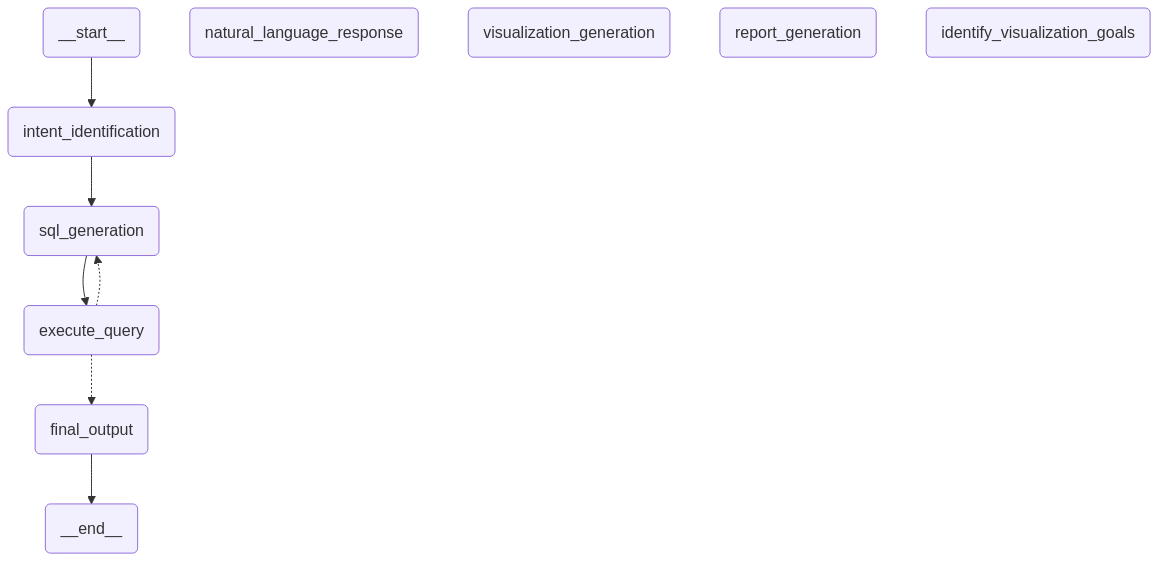

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the StateGraph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [16]:
final_state = app.invoke({"user_query": "How many Residents are in location Los Angeles"})
# Pretty-print the SQL query or queries used:
print("==== SQL Query/Queries Used ====")
sql_queries = final_state.get("sql_queries", [])
if sql_queries:
    for idx, query in enumerate(sql_queries):
        print(f"\nQuery {idx+1}:")
        print(query)
else:
    print("No SQL queries found.")

# Pretty-print the final natural language response:
print("\n==== Final NL Response ====")
response = final_state.get("nl_response", "No response found.")
print(response)

---INTENT IDENTIFICATION---
---SQL GENERATION NODE---
Available tables in DB: []
Executing Query 1: SELECT COUNT(DISTINCT ResidentKey) AS NumResidents
FROM Fact_Census
WHERE LocationKey = (SELECT LocationKey FROM Dim_CensusLocation WHERE LocationName = 'Los Angeles')
Error executing Query 1:
SELECT COUNT(DISTINCT ResidentKey) AS NumResidents
FROM Fact_Census
WHERE LocationKey = (SELECT LocationKey FROM Dim_CensusLocation WHERE LocationName = 'Los Angeles')
Exception: Execution failed on sql 'SELECT COUNT(DISTINCT ResidentKey) AS NumResidents
FROM Fact_Census
WHERE LocationKey = (SELECT LocationKey FROM Dim_CensusLocation WHERE LocationName = 'Los Angeles')': no such table: Fact_Census
---SQL GENERATION NODE---
Available tables in DB: []
Executing Query 1: SELECT COUNT(DISTINCT ResidentKey) AS NumResidents
FROM Fact_Census
WHERE LocationKey = (SELECT LocationKey FROM Dim_CensusLocation WHERE LocationName = 'Los Angeles')
Error executing Query 1:
SELECT COUNT(DISTINCT ResidentKey) AS Num

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT